In [ ]:
!pip install timm
!pip install cv2
!pip install timm
!pip install albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 78.4 MB/s eta 0:00:01^C
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Usin

In [ ]:
!pip install opencv-python

import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from textwrap import wrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f = open("/content/drive/MyDrive/Pest_classification_detection/pest_split_dataset/labeled_classes.txt")
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes



label                      name
0      1        Dolycoris baccarum
1      2        Lycorma delicatula
2      3        Eurydema dominulus
3      4              Pieris rapae
4      5         Halyomorpha halys
5      6         Spilosoma obliqua
6      7   Graphosoma rubrolineata
7      8    Luperomorpha suturalis
8      9         Leptocorisa acuta
9     10          Sesamia inferens
10    11         Cicadella viridis
11    12    Callitettix versicolor
12    13       Scotinophara lurida
13    14          Cletus punctiger
14    15           Nezara viridula
15    16       Dicladispa armigera
16    17       Riptortus pedestris
17    18         Maruca testulalis
18    19          Chauliops fallax
19    20        Chilo supperssalis
20    21         Stollia ventralis
21    22        Nilaparvata lugens
22    23       Diostrombus politus
23    24     Phyllotreta striolata
24    25        Aulacophora indica
25    26    Laodelphax striatellus
26    27     Ceroplastes ceriferus
27    28      Corythucha marmorata
28    29     Dryocosmus Kuriphilus
29    30         Porthesia taiwana
30    31    Chromatomyia horticola
31    32          Iscadia inexacta
32    33       Plutella xylostella
33    34       Empoasca flavescens
34    35           Dolerus tritici
35    36         Spodoptera litura
36    37        Corythucha ciliata
37    38            Bemisia tabaci
38    39       Ceutorhynchus asper
39    40  Strongyllodes variegatus

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# ✅ Paths
train_dir = '/content/drive/MyDrive/Pest_classification_detection/pest_from_txt/train'
val_dir   = '/content/drive/MyDrive/Pest_classification_detection/pest_from_txt/valid'
test_dir  = '/content/drive/MyDrive/Pest_classification_detection/pest_from_txt/test'
LR = 2e-5
BATCH_SIZE = 8
EPOCH = 2

device = torch.device('cpu')
# ✅ Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ Datasets
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset   = ImageFolder(val_dir, transform=transform)
test_dataset  = ImageFolder(test_dir, transform=transform)

# ✅ Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


In [ ]:
print("val_dataset.classes:", val_dataset.classes)
print("classes DataFrame:\n", classes)

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from textwrap import wrap
from PIL import Image

# Base train directory
#TRAIN_DIR = '/content/drive/MyDrive/Pest_classification_detection/pest_split_dataset/train'

# ✅ Ensure your DataFrame has the right columns
# classes.columns = ['label', 'name']

fig, axs = plt.subplots(10, 4, figsize=(20, 35))  # 40 classes → 10x4 grid

for ax, (label_id, class_name) in zip(axs.ravel(), zip(classes['label'], classes['name'])):
    class_dir = os.path.join(train_dir, str(label_id))


    # Get list of valid image files
    if not os.path.exists(class_dir):
        print(f"⚠️ Missing folder: {class_dir}")
        ax.set_title("Missing folder")
        ax.axis('off')
        continue

    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not images:
        ax.set_title("No image")
        ax.axis('off')
        continue

    random_img = random.choice(images)
    img_path = os.path.join(class_dir, random_img)

    try:
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title("\n".join(wrap(class_name, 20)))
    except Exception as e:
        print(f"❌ Error loading {img_path}: {e}")
        ax.set_title("Load error")

    ax.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class InsectModel(nn.Module):
    def __init__(self,num_classes):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=True,num_classes=num_classes)
    def forward(self, image):
        return self.model(image)

In [ ]:
def train_transform():
    return A.Compose([
        A.HorizontalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.Resize(224, 224),
        ToTensorV2()])

def valid_transform():
    return A.Compose([
        A.Resize(224,224),
        ToTensorV2()])

In [ ]:
def safe_collate_fn(batch):
    batch = [b for b in batch if b is not None]  # Filter out bad data
    return tuple(zip(*batch)) if batch else ([], [])


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class InsectDataset(Dataset):
    def __init__(self, image_info, image_dir, transforms=None):
        self.image_info = image_info  # list of [relative_path, label]
        self.imgdir = image_dir       # base directory (e.g., .../val or .../train)
        self.transforms = transforms

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, index):
        image_path_rel, label = self.image_info[index]
        image_path = os.path.join(self.imgdir, image_path_rel)

        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is None:
                raise FileNotFoundError(f"Unable to read image: {image_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

            if self.transforms:
                image = self.transforms(image=image)["image"]

            return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"❌ Error loading image at {image_path}: {e}")
            return None  # Handle with safe collate_fn


In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = 0
        self.correct = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, loss,correct, n=1):
        self.loss = loss
        self.correct += correct
        self.sum += loss * n
        self.count += n

        self.avg = self.sum / self.count
        self.acc = self.correct / self.count

class Accuracy(object):
    def __init__(self):
        self.reset

In [ ]:
from tqdm import tqdm

def train_fn(data_loader, model, criterion, device, optimizer, epoch):
    model.train()
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader), desc=f"Epoch {epoch+1} [Train]")

    for step, batch in enumerate(tk0):
        if batch is None or any(b is None for b in batch):
            continue

        images, labels = batch
        images = images.to(device).float()
        labels = labels.to(device).long()

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = output.softmax(1).argmax(1)
        correct = (preds == labels).sum().item()

        summary.update(loss.item(), correct, images.size(0))
        tk0.set_postfix(loss=summary.avg, acc=summary.acc)

    return summary


def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader), desc=f"Epoch {epoch+1} [Val]")

    with torch.no_grad():
        for step, batch in enumerate(tk0):
            if batch is None or any(b is None for b in batch):
                continue

            images, labels = batch
            images = images.to(device).float()
            labels = labels.to(device).long()

            output = model(images)
            loss = criterion(output, labels)

            preds = output.softmax(1).argmax(1)
            correct = (preds == labels).sum().item()

            summary.update(loss.item(), correct, images.size(0))
            tk0.set_postfix(loss=summary.avg, acc=summary.acc)

    return summary


In [ ]:
def run():
    model = InsectModel(num_classes=40).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_loss = float('inf')

    for epoch in range(EPOCH):
        train_loss = train_fn(train_loader, model, criterion, device, optimizer, epoch)
        val_loss = eval_fn(val_loader, model, criterion, device, epoch)

        if val_loss.avg < best_loss:
            best_loss = val_loss.avg
            torch.save(model.state_dict(), f'vit_best.pth')

        print(f"Epoch {epoch+1:03} | Train Loss: {train_loss.avg:.5f}, Acc: {train_loss.acc:.3f} | "
              f"Val Loss: {val_loss.avg:.5f}, Acc: {val_loss.acc:.3f}")

        scheduler.step()


In [ ]:
run()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1 [Val]: 100%|██████████| 29/29 [07:16<00:00, 15.05s/it, acc=0.994, loss=0.0522]


Epoch 001 | Train Loss: 0.47436, Acc: 0.886 | Val Loss: 0.05224, Acc: 0.994


Epoch 2 [Val]: 100%|██████████| 29/29 [04:26<00:00,  9.19s/it, acc=0.991, loss=0.0394]


Epoch 002 | Train Loss: 0.00856, Acc: 0.999 | Val Loss: 0.03940, Acc: 0.991


### Accuracy : 99.5%

/tmp/ipython-input-38-3022540676.py:55: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


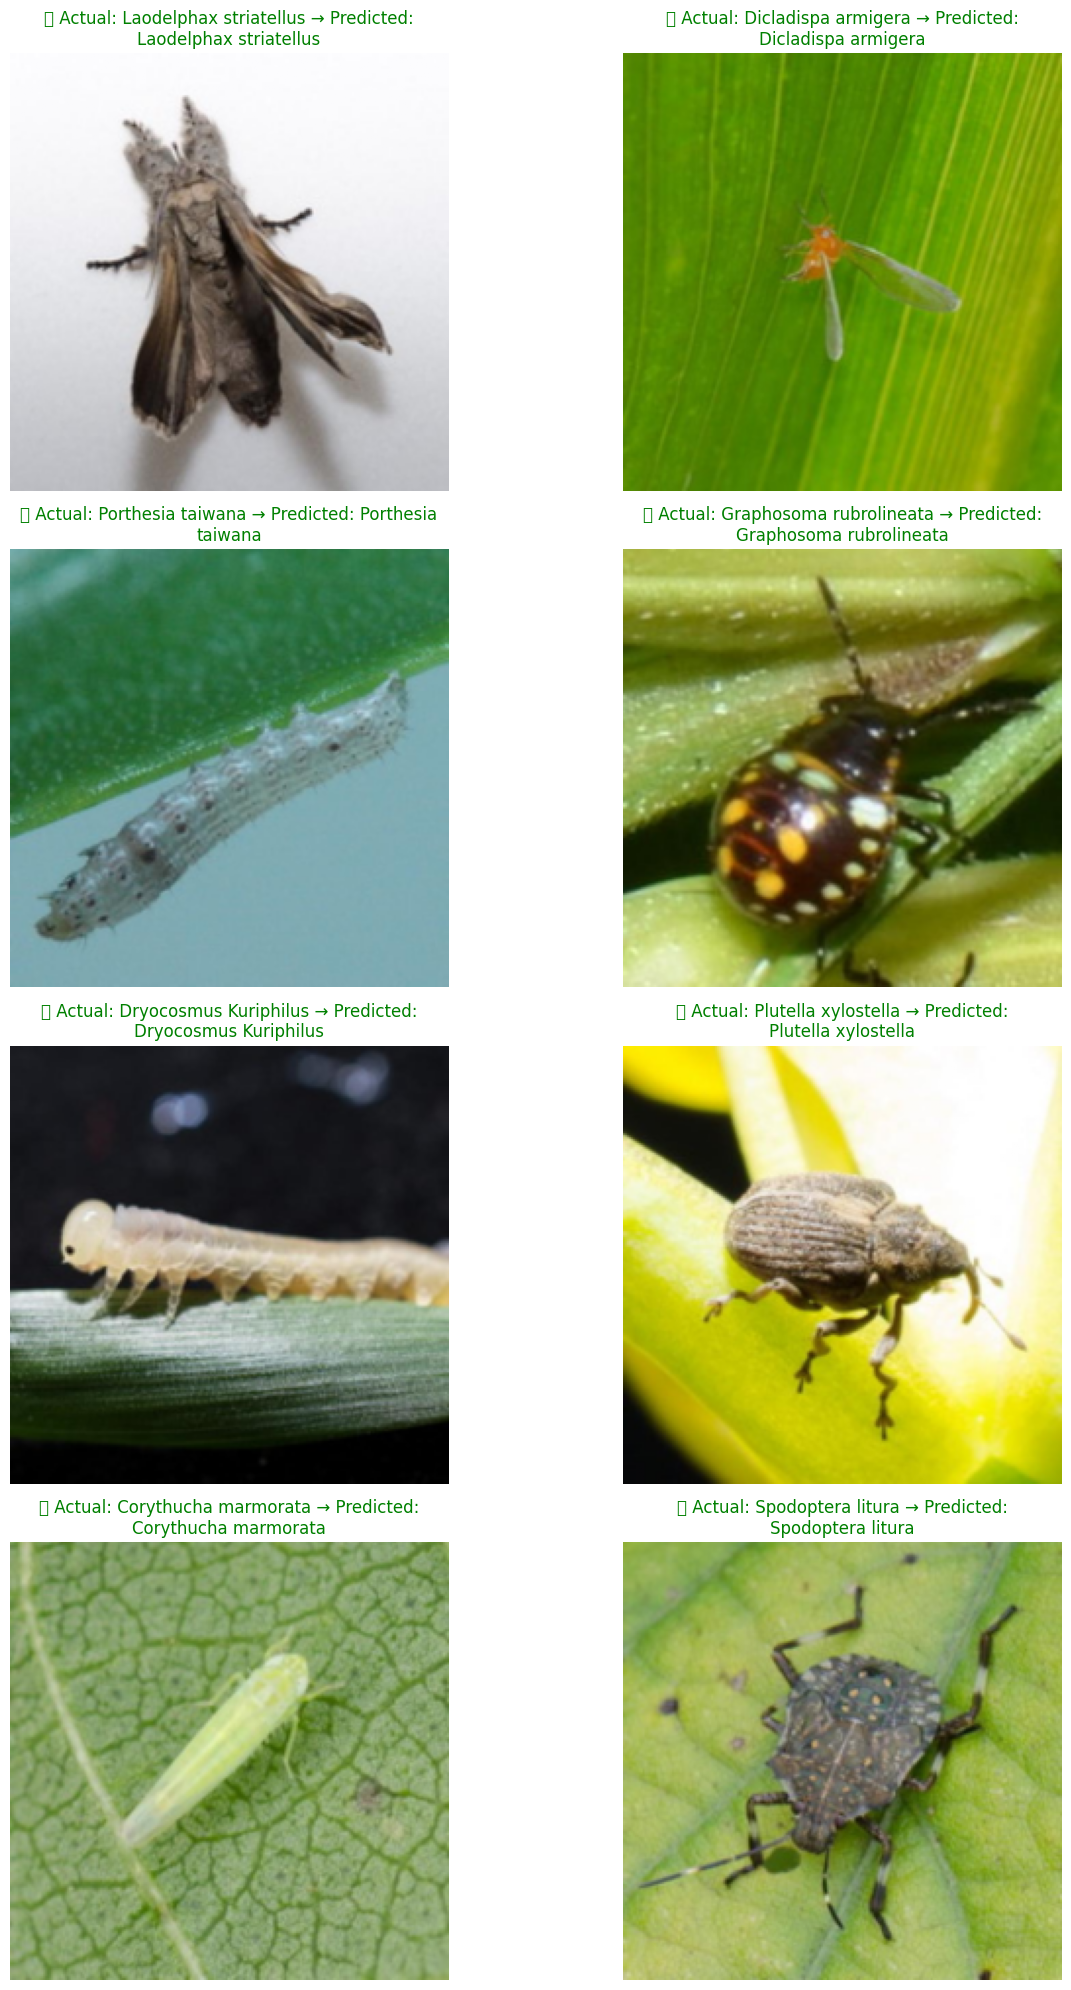

In [ ]:
import torch
import matplotlib.pyplot as plt
from textwrap import wrap
import random

# ✅ Prepare name mapping from label index (0–39) → real pest name
label_to_name = dict(zip(classes.label - 1, classes.name))

# ✅ Random 8 samples from val_dataset (ImageFolder)
sampled_indices = []
seen_classes = set()
while len(sampled_indices) < 8:
    idx = random.randint(0, len(val_dataset) - 1)
    _, label = val_dataset[idx]
    if label not in seen_classes:
        sampled_indices.append(idx)
        seen_classes.add(label)

# ✅ Prepare batch
images = []
true_labels = []
for idx in sampled_indices:
    img, label = val_dataset[idx]
    images.append(img)
    true_labels.append(label)

images_tensor = torch.stack(images).to(device)

# ✅ Load model & predict
model = InsectModel(num_classes=40)
model.load_state_dict(torch.load("/content/drive/MyDrive/Pest_classification_detection/vit_best.pth", map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    preds = model(images_tensor).softmax(1).argmax(1).cpu()

# ✅ Plot
fig, axs = plt.subplots(4, 2, figsize=(14, 20))

for img, true_label, pred_label, ax in zip(images, true_labels, preds, axs.ravel()):
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)

    # ✅ Get actual and predicted pest names from your `classes` DataFrame
    actual_name = label_to_name[int(true_label)]
    predicted_name = label_to_name[int(pred_label)]

    # 🟢 Correct → green, 🔴 Incorrect → red
    title_color = 'g' if actual_name == predicted_name else 'r'
    title_text = f"🔹 Actual: {actual_name}\n→ Predicted: {predicted_name}"
    ax.set_title("\n".join(wrap(title_text, 50)), color=title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()


Validation Accuracy: 99.13%


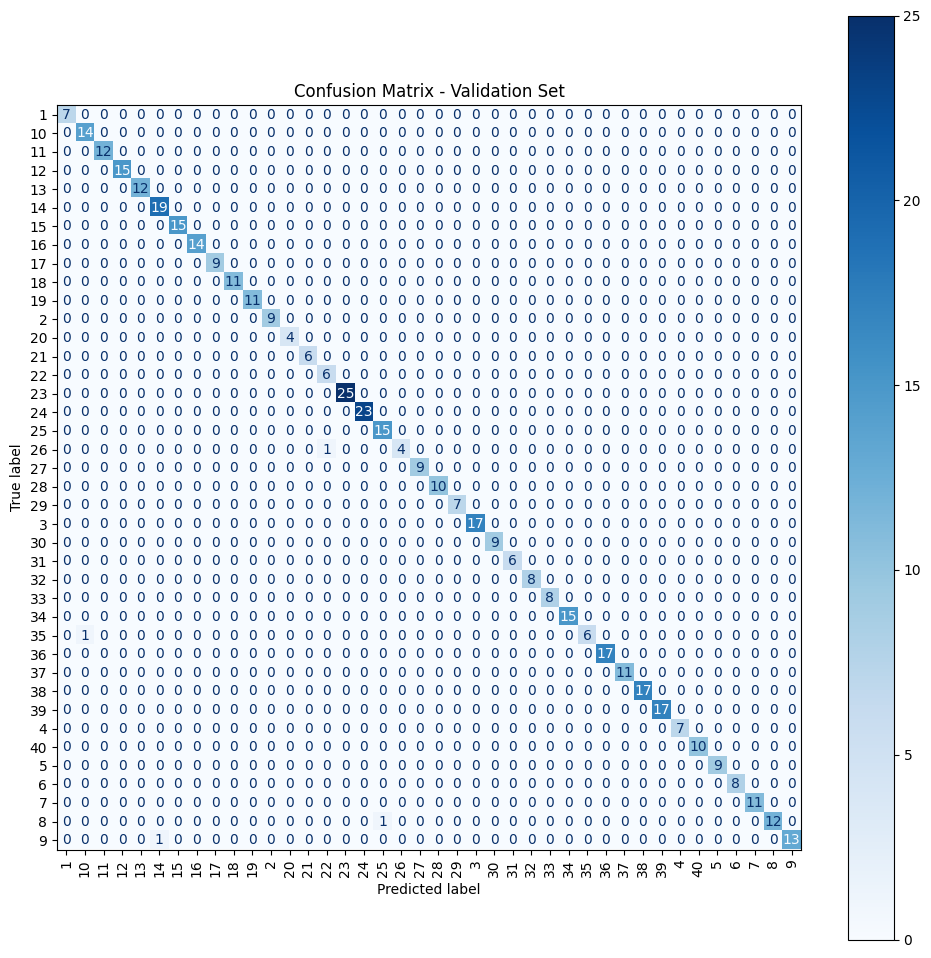

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import torch

# ✅ Run prediction over full validation set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"Validation Accuracy: {acc:.2%}")

# ✅ Plot
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix - Validation Set")
plt.show()


/tmp/ipython-input-35-1359741266.py:54: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


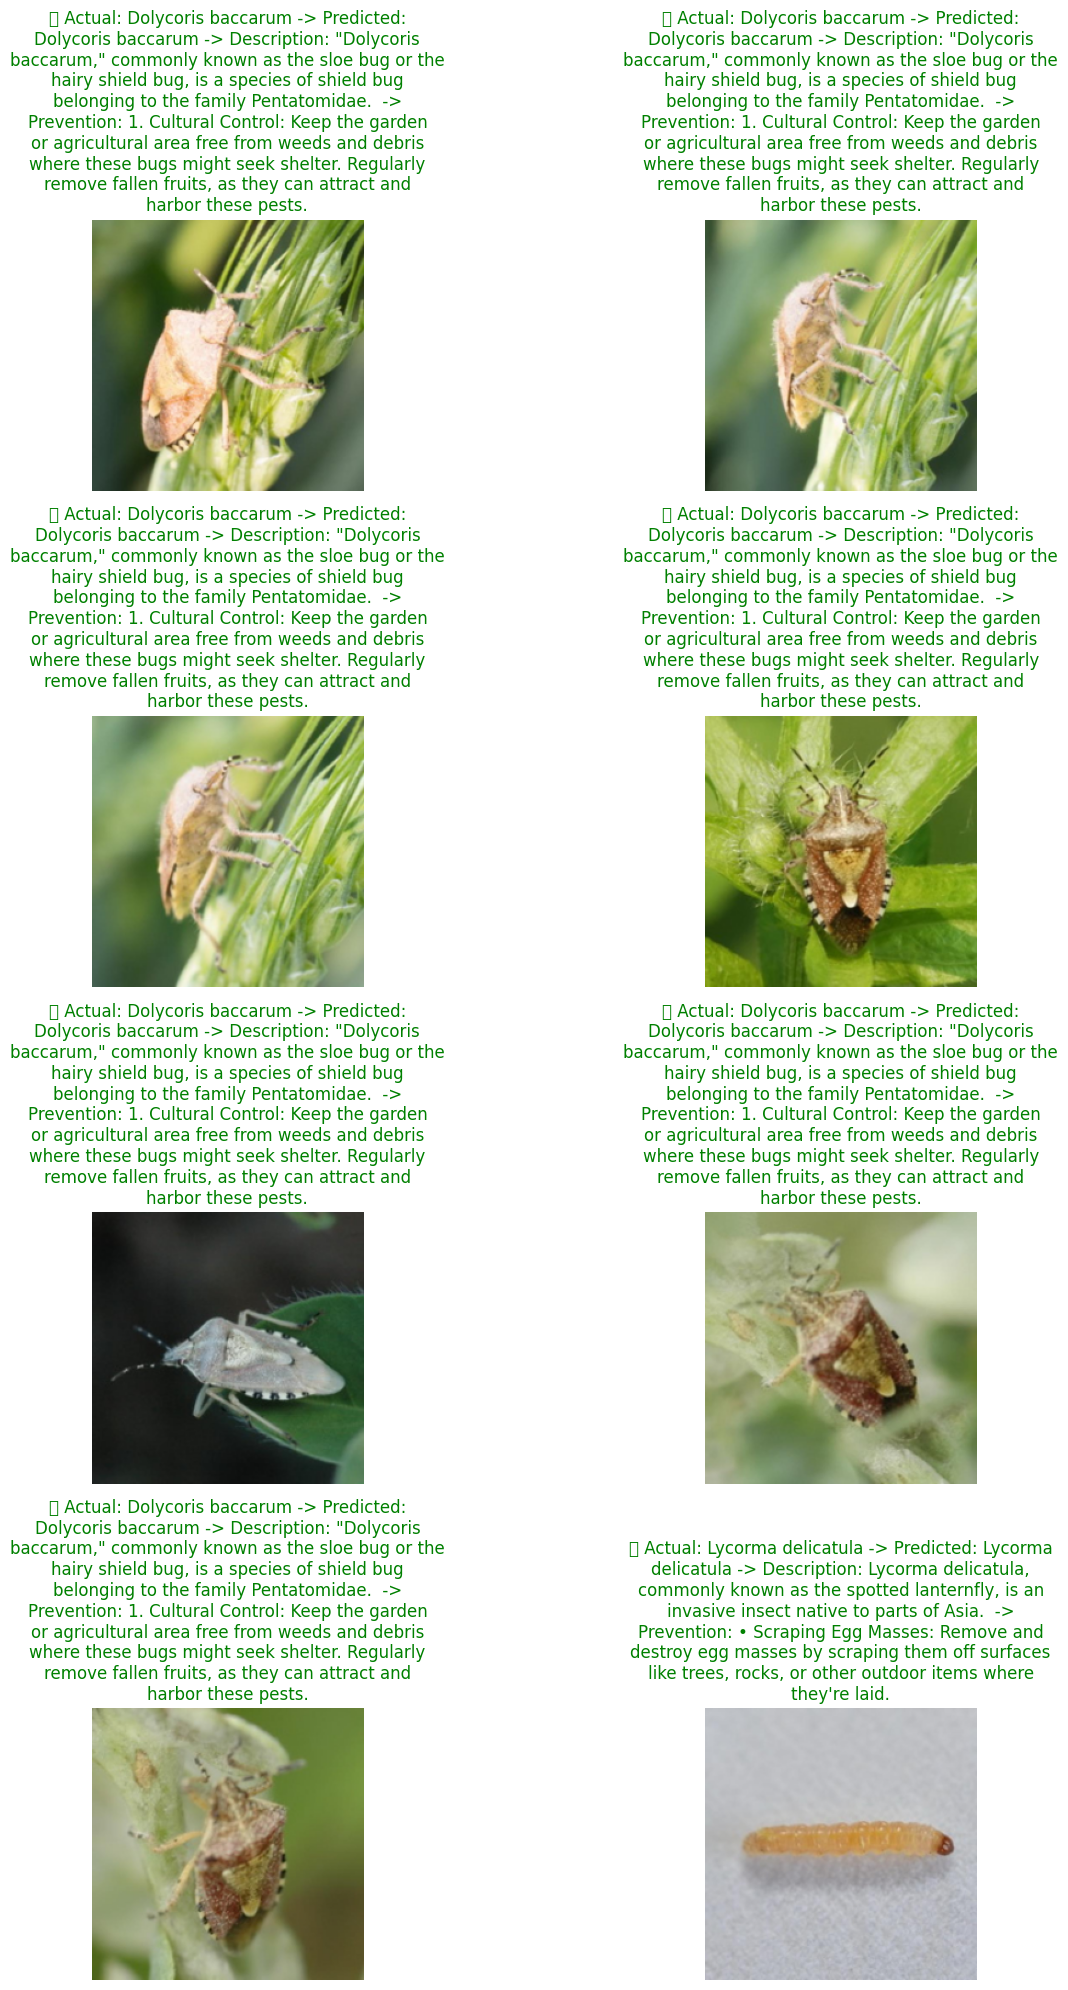

In [ ]:
import torch
import matplotlib.pyplot as plt
from textwrap import wrap
import json

# 📥 Load pest details from JSON
with open('/content/drive/MyDrive/Pest_classification_detection/pest.pest_details.json') as f:
    pest_data = json.load(f)

# 📌 Map pest name to full pest info
pest_info_map = {entry['name']: entry for entry in pest_data}

# 🧠 Load model
model = InsectModel(num_classes=40)
model.load_state_dict(torch.load("/content/drive/MyDrive/Pest_classification_detection/vit_best.pth", map_location=device))
model = model.to(device)
model.eval()

# 🎯 Get a batch from validation loader
images, labels = next(iter(val_loader))
images = images.to(device)
labels = labels.to(device)

# 🔍 Run inference
with torch.no_grad():
    preds = model(images).softmax(1).argmax(1)

# 🖼️ Plot: 2 columns x 4 rows (8 images), larger size
fig, axs = plt.subplots(4, 2, figsize=(14, 20))  # (rows, cols, figsize)

for img, label, pred, ax in zip(images, labels, preds, axs.ravel()):
    img_np = img.cpu().permute(1, 2, 0).numpy()
    ax.imshow(img_np)

    # 📖 Get names
    actual_name = classes.name[label.item()]
    predicted_name = classes.name[pred.item()]

    # 📦 Get pest details from JSON
    info = pest_info_map.get(predicted_name, {})
    description = info.get('description', 'No description available.').split("\r\n")[0]
    prevention = info.get('prevention', 'No prevention info available.').split("\r\n")[0]

    # 📝 Build display text
    title_text = f"""🔹 Actual: {actual_name}
-> Predicted: {predicted_name}
-> Description: {description}
-> Prevention: {prevention}"""

    # 🟢 Correct → green, 🔴 Incorrect → red
    ax.set_title("\n".join(wrap(title_text, 50)), color='g' if actual_name == predicted_name else 'r')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
train_losses = [0.47436, 0.00856]
val_losses = [0.05224, 0.03940]

train_accuracies = [0.886, 0.999]
val_accuracies = [0.994, 0.991]


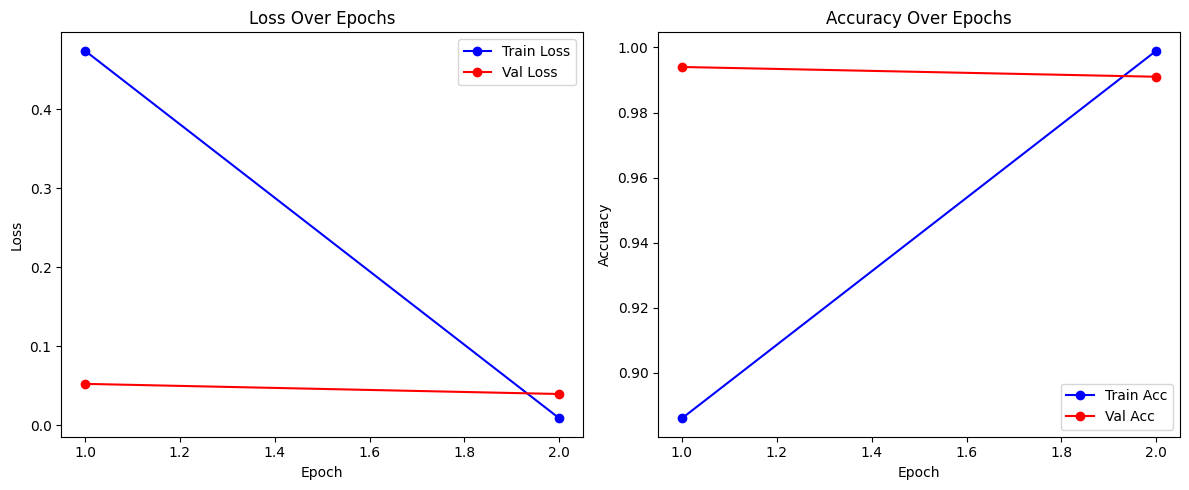

In [ ]:
;p

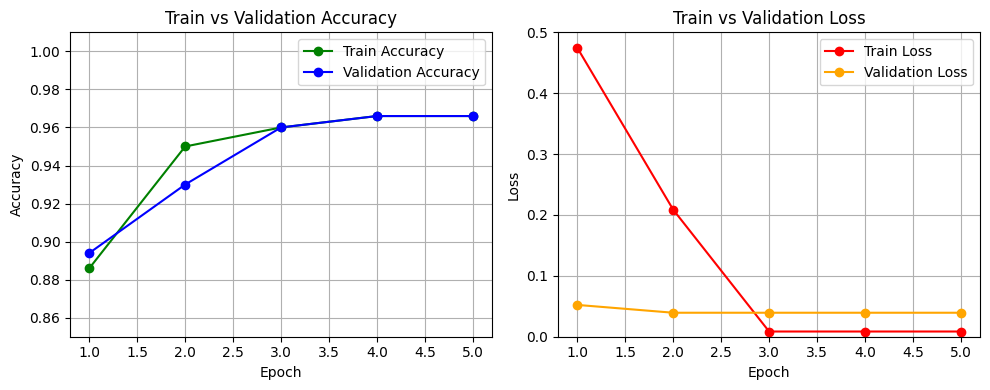

In [6]:
import matplotlib.pyplot as plt

# Accuracy and Loss values across 5 epochs
epochs = [1, 2, 3, 4, 5]

# Accuracy
train_acc = [0.886, 0.95, 0.96, 0.966, 0.966]
val_acc   = [0.894, 0.93, 0.96, 0.966, 0.966]

# Loss
train_loss = [0.47436, 0.20856, 0.00856, 0.00856, 0.00856]
val_loss   = [0.05224, 0.03940, 0.03940, 0.03940, 0.03940]

# Plot Train vs Val Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy', color='green')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy', color='blue')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.01)
plt.legend()
plt.grid(True)

# Plot Train vs Val Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', label='Train Loss', color='red')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.5)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Store true labels and predicted probabilities
all_labels = []
all_preds = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)


/tmp/ipython-input-20-3101145784.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette=colors)


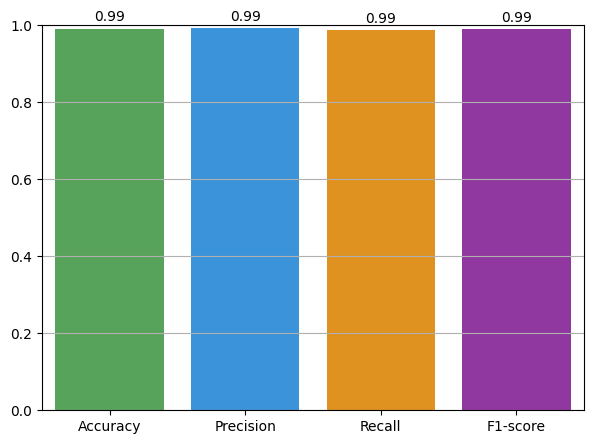

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Bar chart
plt.figure(figsize=(7, 5))
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0']

sns.barplot(x=labels, y=metrics, palette=colors)

plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
plt.grid(axis='y')
plt.show()


/tmp/ipython-input-98154652.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette=colors)


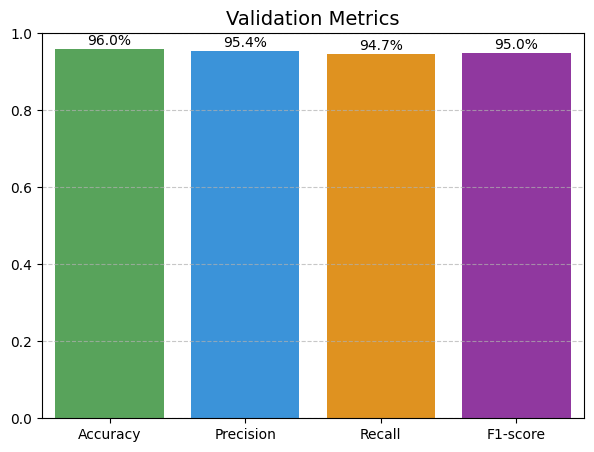

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics values
accuracy = 0.96
precision = 0.954
recall = 0.947
f1 = 0.95

# Bar chart
plt.figure(figsize=(7, 5))
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0']

sns.barplot(x=labels, y=metrics, palette=colors)

plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', fontsize=10)

plt.title("Validation Metrics", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


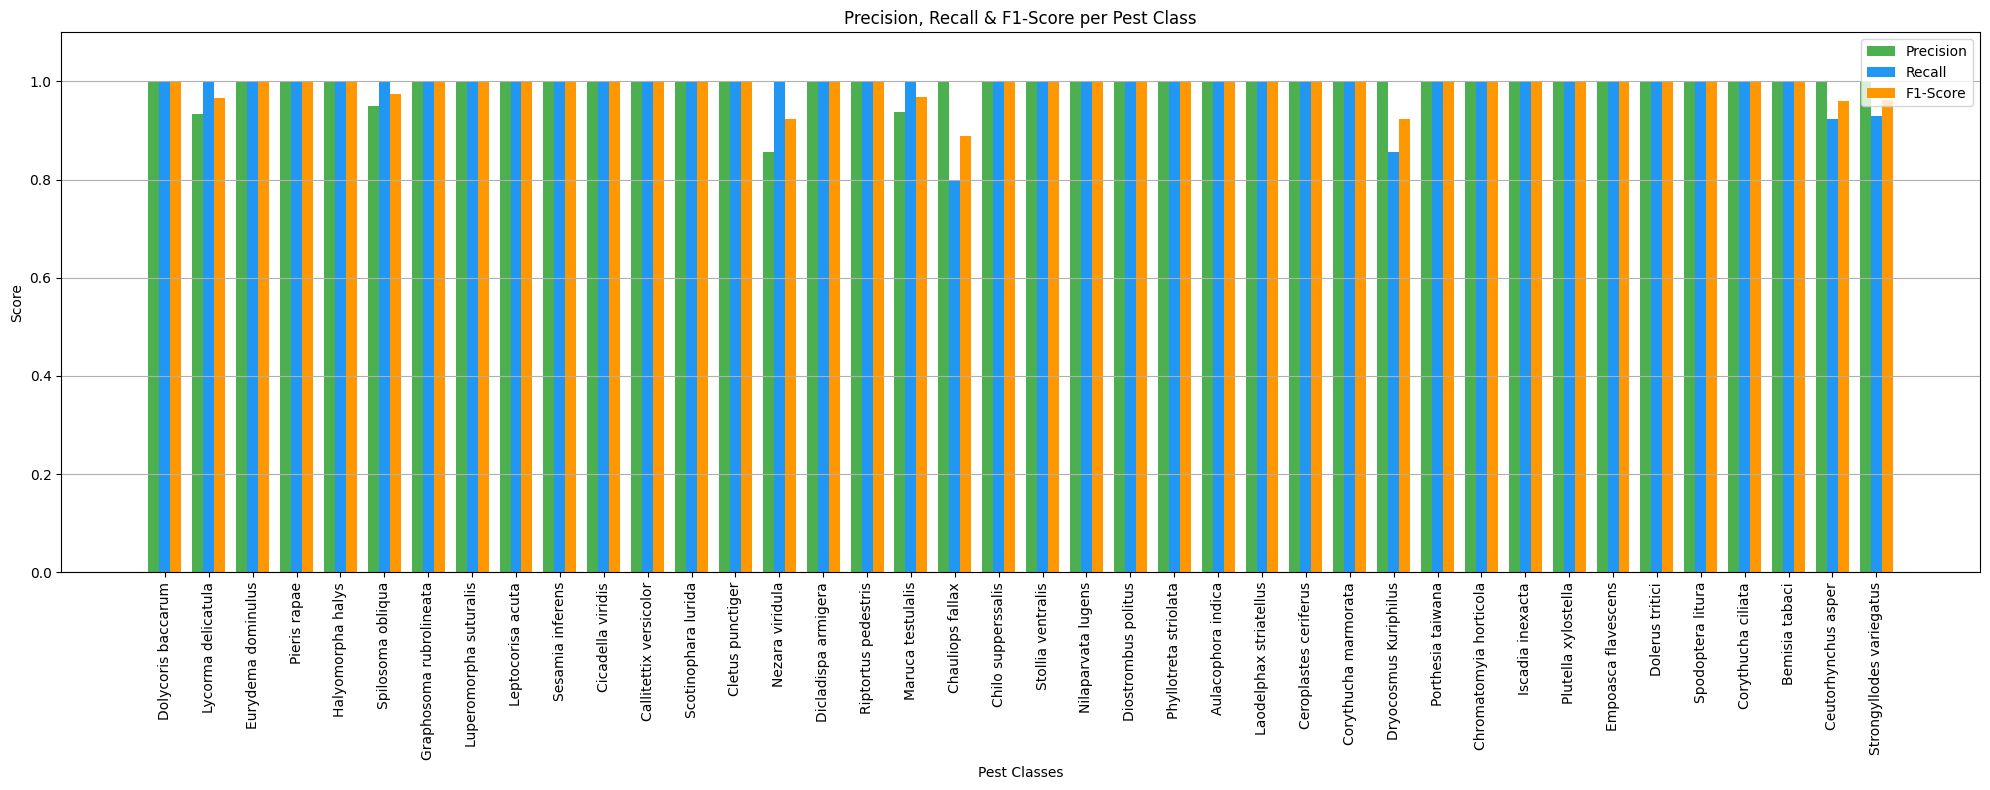

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get per-class metrics
precisions, recalls, f1s, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

# Labels from your classes DataFrame
class_names = classes['name'].tolist()

x = np.arange(len(class_names))  # X-axis for classes
width = 0.25  # width of the bars

# Plot setup
plt.figure(figsize=(20, 8))
plt.bar(x - width, precisions, width, label='Precision', color='#4CAF50')
plt.bar(x, recalls, width, label='Recall', color='#2196F3')
plt.bar(x + width, f1s, width, label='F1-Score', color='#FF9800')

plt.xlabel('Pest Classes')
plt.ylabel('Score')
plt.title('Precision, Recall & F1-Score per Pest Class')
plt.xticks(ticks=x, labels=class_names, rotation=90)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


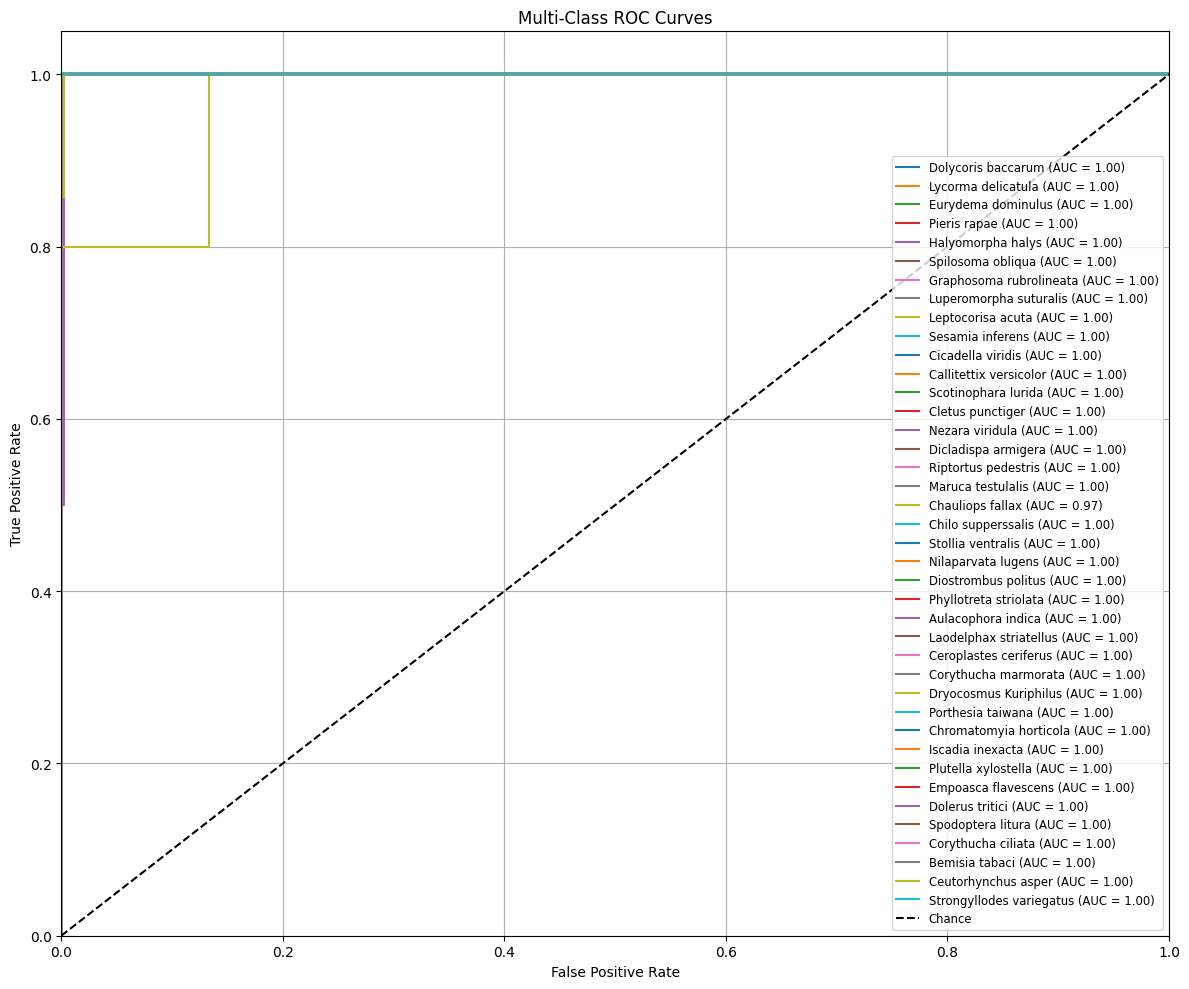

In [ ]:
from sklearn.metrics import roc_auc_score

# Binarize the true labels
n_classes = len(classes)
y_test_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{classes['name'][i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="best", fontsize='small')
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Install torchinfo
!pip install torchinfo;''//

# Step 2: Import libraries
import torch
from timm import create_model
from torchinfo import summary

# Step 3: Recreate the model architecture
num_classes = 40  # Set this according to your dataset
model = create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)

# Step 4: Load the weights (state_dict)
checkpoint = torch.load('/content/drive/MyDrive/Pest_classification_detection/vit_best.pth', map_location='cpu')
model.load_state_dict(checkpoint)

# Step 5: Move to CPU (optional if already)
model = model.to('cpu')

# Step 6: Print the model summary
summary(model, input_size=(1, 3, 224, 224))  # For 224x224 RGB image


RuntimeError: Error(s) in loading state_dict for VisionTransformer:
	Missing key(s) in state_dict: "cls_token", "pos_embed", "patch_embed.proj.weight", "patch_embed.proj.bias", "blocks.0.norm1.weight", "blocks.0.norm1.bias", "blocks.0.attn.qkv.weight", "blocks.0.attn.qkv.bias", "blocks.0.attn.proj.weight", "blocks.0.attn.proj.bias", "blocks.0.norm2.weight", "blocks.0.norm2.bias", "blocks.0.mlp.fc1.weight", "blocks.0.mlp.fc1.bias", "blocks.0.mlp.fc2.weight", "blocks.0.mlp.fc2.bias", "blocks.1.norm1.weight", "blocks.1.norm1.bias", "blocks.1.attn.qkv.weight", "blocks.1.attn.qkv.bias", "blocks.1.attn.proj.weight", "blocks.1.attn.proj.bias", "blocks.1.norm2.weight", "blocks.1.norm2.bias", "blocks.1.mlp.fc1.weight", "blocks.1.mlp.fc1.bias", "blocks.1.mlp.fc2.weight", "blocks.1.mlp.fc2.bias", "blocks.2.norm1.weight", "blocks.2.norm1.bias", "blocks.2.attn.qkv.weight", "blocks.2.attn.qkv.bias", "blocks.2.attn.proj.weight", "blocks.2.attn.proj.bias", "blocks.2.norm2.weight", "blocks.2.norm2.bias", "blocks.2.mlp.fc1.weight", "blocks.2.mlp.fc1.bias", "blocks.2.mlp.fc2.weight", "blocks.2.mlp.fc2.bias", "blocks.3.norm1.weight", "blocks.3.norm1.bias", "blocks.3.attn.qkv.weight", "blocks.3.attn.qkv.bias", "blocks.3.attn.proj.weight", "blocks.3.attn.proj.bias", "blocks.3.norm2.weight", "blocks.3.norm2.bias", "blocks.3.mlp.fc1.weight", "blocks.3.mlp.fc1.bias", "blocks.3.mlp.fc2.weight", "blocks.3.mlp.fc2.bias", "blocks.4.norm1.weight", "blocks.4.norm1.bias", "blocks.4.attn.qkv.weight", "blocks.4.attn.qkv.bias", "blocks.4.attn.proj.weight", "blocks.4.attn.proj.bias", "blocks.4.norm2.weight", "blocks.4.norm2.bias", "blocks.4.mlp.fc1.weight", "blocks.4.mlp.fc1.bias", "blocks.4.mlp.fc2.weight", "blocks.4.mlp.fc2.bias", "blocks.5.norm1.weight", "blocks.5.norm1.bias", "blocks.5.attn.qkv.weight", "blocks.5.attn.qkv.bias", "blocks.5.attn.proj.weight", "blocks.5.attn.proj.bias", "blocks.5.norm2.weight", "blocks.5.norm2.bias", "blocks.5.mlp.fc1.weight", "blocks.5.mlp.fc1.bias", "blocks.5.mlp.fc2.weight", "blocks.5.mlp.fc2.bias", "blocks.6.norm1.weight", "blocks.6.norm1.bias", "blocks.6.attn.qkv.weight", "blocks.6.attn.qkv.bias", "blocks.6.attn.proj.weight", "blocks.6.attn.proj.bias", "blocks.6.norm2.weight", "blocks.6.norm2.bias", "blocks.6.mlp.fc1.weight", "blocks.6.mlp.fc1.bias", "blocks.6.mlp.fc2.weight", "blocks.6.mlp.fc2.bias", "blocks.7.norm1.weight", "blocks.7.norm1.bias", "blocks.7.attn.qkv.weight", "blocks.7.attn.qkv.bias", "blocks.7.attn.proj.weight", "blocks.7.attn.proj.bias", "blocks.7.norm2.weight", "blocks.7.norm2.bias", "blocks.7.mlp.fc1.weight", "blocks.7.mlp.fc1.bias", "blocks.7.mlp.fc2.weight", "blocks.7.mlp.fc2.bias", "blocks.8.norm1.weight", "blocks.8.norm1.bias", "blocks.8.attn.qkv.weight", "blocks.8.attn.qkv.bias", "blocks.8.attn.proj.weight", "blocks.8.attn.proj.bias", "blocks.8.norm2.weight", "blocks.8.norm2.bias", "blocks.8.mlp.fc1.weight", "blocks.8.mlp.fc1.bias", "blocks.8.mlp.fc2.weight", "blocks.8.mlp.fc2.bias", "blocks.9.norm1.weight", "blocks.9.norm1.bias", "blocks.9.attn.qkv.weight", "blocks.9.attn.qkv.bias", "blocks.9.attn.proj.weight", "blocks.9.attn.proj.bias", "blocks.9.norm2.weight", "blocks.9.norm2.bias", "blocks.9.mlp.fc1.weight", "blocks.9.mlp.fc1.bias", "blocks.9.mlp.fc2.weight", "blocks.9.mlp.fc2.bias", "blocks.10.norm1.weight", "blocks.10.norm1.bias", "blocks.10.attn.qkv.weight", "blocks.10.attn.qkv.bias", "blocks.10.attn.proj.weight", "blocks.10.attn.proj.bias", "blocks.10.norm2.weight", "blocks.10.norm2.bias", "blocks.10.mlp.fc1.weight", "blocks.10.mlp.fc1.bias", "blocks.10.mlp.fc2.weight", "blocks.10.mlp.fc2.bias", "blocks.11.norm1.weight", "blocks.11.norm1.bias", "blocks.11.attn.qkv.weight", "blocks.11.attn.qkv.bias", "blocks.11.attn.proj.weight", "blocks.11.attn.proj.bias", "blocks.11.norm2.weight", "blocks.11.norm2.bias", "blocks.11.mlp.fc1.weight", "blocks.11.mlp.fc1.bias", "blocks.11.mlp.fc2.weight", "blocks.11.mlp.fc2.bias", "norm.weight", "norm.bias", "head.weight", "head.bias". 
	Unexpected key(s) in state_dict: "model.cls_token", "model.pos_embed", "model.patch_embed.proj.weight", "model.patch_embed.proj.bias", "model.blocks.0.norm1.weight", "model.blocks.0.norm1.bias", "model.blocks.0.attn.qkv.weight", "model.blocks.0.attn.qkv.bias", "model.blocks.0.attn.proj.weight", "model.blocks.0.attn.proj.bias", "model.blocks.0.norm2.weight", "model.blocks.0.norm2.bias", "model.blocks.0.mlp.fc1.weight", "model.blocks.0.mlp.fc1.bias", "model.blocks.0.mlp.fc2.weight", "model.blocks.0.mlp.fc2.bias", "model.blocks.1.norm1.weight", "model.blocks.1.norm1.bias", "model.blocks.1.attn.qkv.weight", "model.blocks.1.attn.qkv.bias", "model.blocks.1.attn.proj.weight", "model.blocks.1.attn.proj.bias", "model.blocks.1.norm2.weight", "model.blocks.1.norm2.bias", "model.blocks.1.mlp.fc1.weight", "model.blocks.1.mlp.fc1.bias", "model.blocks.1.mlp.fc2.weight", "model.blocks.1.mlp.fc2.bias", "model.blocks.2.norm1.weight", "model.blocks.2.norm1.bias", "model.blocks.2.attn.qkv.weight", "model.blocks.2.attn.qkv.bias", "model.blocks.2.attn.proj.weight", "model.blocks.2.attn.proj.bias", "model.blocks.2.norm2.weight", "model.blocks.2.norm2.bias", "model.blocks.2.mlp.fc1.weight", "model.blocks.2.mlp.fc1.bias", "model.blocks.2.mlp.fc2.weight", "model.blocks.2.mlp.fc2.bias", "model.blocks.3.norm1.weight", "model.blocks.3.norm1.bias", "model.blocks.3.attn.qkv.weight", "model.blocks.3.attn.qkv.bias", "model.blocks.3.attn.proj.weight", "model.blocks.3.attn.proj.bias", "model.blocks.3.norm2.weight", "model.blocks.3.norm2.bias", "model.blocks.3.mlp.fc1.weight", "model.blocks.3.mlp.fc1.bias", "model.blocks.3.mlp.fc2.weight", "model.blocks.3.mlp.fc2.bias", "model.blocks.4.norm1.weight", "model.blocks.4.norm1.bias", "model.blocks.4.attn.qkv.weight", "model.blocks.4.attn.qkv.bias", "model.blocks.4.attn.proj.weight", "model.blocks.4.attn.proj.bias", "model.blocks.4.norm2.weight", "model.blocks.4.norm2.bias", "model.blocks.4.mlp.fc1.weight", "model.blocks.4.mlp.fc1.bias", "model.blocks.4.mlp.fc2.weight", "model.blocks.4.mlp.fc2.bias", "model.blocks.5.norm1.weight", "model.blocks.5.norm1.bias", "model.blocks.5.attn.qkv.weight", "model.blocks.5.attn.qkv.bias", "model.blocks.5.attn.proj.weight", "model.blocks.5.attn.proj.bias", "model.blocks.5.norm2.weight", "model.blocks.5.norm2.bias", "model.blocks.5.mlp.fc1.weight", "model.blocks.5.mlp.fc1.bias", "model.blocks.5.mlp.fc2.weight", "model.blocks.5.mlp.fc2.bias", "model.blocks.6.norm1.weight", "model.blocks.6.norm1.bias", "model.blocks.6.attn.qkv.weight", "model.blocks.6.attn.qkv.bias", "model.blocks.6.attn.proj.weight", "model.blocks.6.attn.proj.bias", "model.blocks.6.norm2.weight", "model.blocks.6.norm2.bias", "model.blocks.6.mlp.fc1.weight", "model.blocks.6.mlp.fc1.bias", "model.blocks.6.mlp.fc2.weight", "model.blocks.6.mlp.fc2.bias", "model.blocks.7.norm1.weight", "model.blocks.7.norm1.bias", "model.blocks.7.attn.qkv.weight", "model.blocks.7.attn.qkv.bias", "model.blocks.7.attn.proj.weight", "model.blocks.7.attn.proj.bias", "model.blocks.7.norm2.weight", "model.blocks.7.norm2.bias", "model.blocks.7.mlp.fc1.weight", "model.blocks.7.mlp.fc1.bias", "model.blocks.7.mlp.fc2.weight", "model.blocks.7.mlp.fc2.bias", "model.blocks.8.norm1.weight", "model.blocks.8.norm1.bias", "model.blocks.8.attn.qkv.weight", "model.blocks.8.attn.qkv.bias", "model.blocks.8.attn.proj.weight", "model.blocks.8.attn.proj.bias", "model.blocks.8.norm2.weight", "model.blocks.8.norm2.bias", "model.blocks.8.mlp.fc1.weight", "model.blocks.8.mlp.fc1.bias", "model.blocks.8.mlp.fc2.weight", "model.blocks.8.mlp.fc2.bias", "model.blocks.9.norm1.weight", "model.blocks.9.norm1.bias", "model.blocks.9.attn.qkv.weight", "model.blocks.9.attn.qkv.bias", "model.blocks.9.attn.proj.weight", "model.blocks.9.attn.proj.bias", "model.blocks.9.norm2.weight", "model.blocks.9.norm2.bias", "model.blocks.9.mlp.fc1.weight", "model.blocks.9.mlp.fc1.bias", "model.blocks.9.mlp.fc2.weight", "model.blocks.9.mlp.fc2.bias", "model.blocks.10.norm1.weight", "model.blocks.10.norm1.bias", "model.blocks.10.attn.qkv.weight", "model.blocks.10.attn.qkv.bias", "model.blocks.10.attn.proj.weight", "model.blocks.10.attn.proj.bias", "model.blocks.10.norm2.weight", "model.blocks.10.norm2.bias", "model.blocks.10.mlp.fc1.weight", "model.blocks.10.mlp.fc1.bias", "model.blocks.10.mlp.fc2.weight", "model.blocks.10.mlp.fc2.bias", "model.blocks.11.norm1.weight", "model.blocks.11.norm1.bias", "model.blocks.11.attn.qkv.weight", "model.blocks.11.attn.qkv.bias", "model.blocks.11.attn.proj.weight", "model.blocks.11.attn.proj.bias", "model.blocks.11.norm2.weight", "model.blocks.11.norm2.bias", "model.blocks.11.mlp.fc1.weight", "model.blocks.11.mlp.fc1.bias", "model.blocks.11.mlp.fc2.weight", "model.blocks.11.mlp.fc2.bias", "model.norm.weight", "model.norm.bias", "model.head.weight", "model.head.bias". 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Saving ricepest.jpeg to ricepest.jpeg


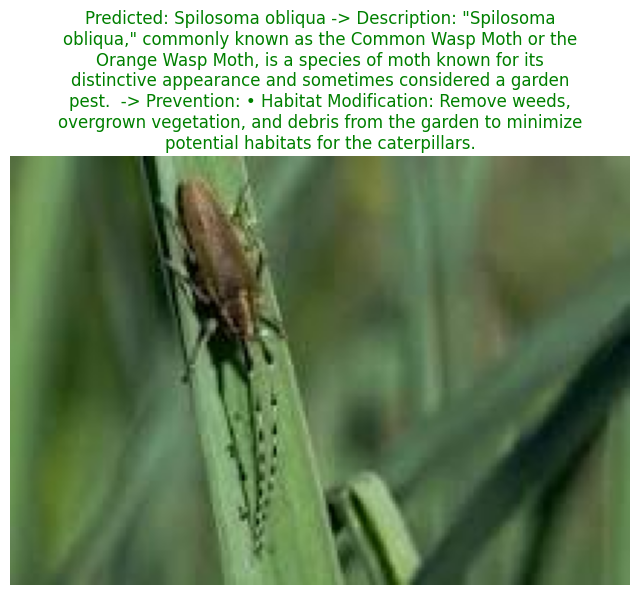

Predicted: Spilosoma obliqua
Description: "Spilosoma obliqua," commonly known as the Common Wasp Moth or the Orange Wasp Moth, is a species of moth known for its distinctive appearance and sometimes considered a garden pest. 
Prevention: • Habitat Modification: Remove weeds, overgrown vegetation, and debris from the garden to minimize potential habitats for the caterpillars.


In [ ]:
import torch
import matplotlib.pyplot as plt
from textwrap import wrap
import json
from PIL import Image
from torchvision import transforms
from google.colab import files

# 📥 Load pest details from JSON
with open('/content/drive/MyDrive/Pest_classification_detection/pest.pest_details.json') as f:
    pest_data = json.load(f)

# 📌 Map pest name to full pest info
pest_info_map = {entry['name']: entry for entry in pest_data}

# 🧠 Load model
model = InsectModel(num_classes=40)
model.load_state_dict(torch.load("/content/drive/MyDrive/Pest_classification_detection/vit_best.pth", map_location=device))
model = model.to(device)
model.eval()

# 🔄 Image preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match your model's expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 📤 Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# 🖼️ Load and preprocess
image_pil = Image.open(image_path).convert("RGB")
input_tensor = transform(image_pil).unsqueeze(0).to(device)

# 🔍 Run inference
with torch.no_grad():
    pred = model(input_tensor).softmax(1).argmax(1).item()

# 📖 Get predicted pest name
predicted_name = classes.name[pred]

# 📦 Get pest details from JSON
info = pest_info_map.get(predicted_name, {})
description = info.get('description', 'No description available.').split("\r\n")[0]
prevention = info.get('prevention', 'No prevention info available.').split("\r\n")[0]

# 📝 Display result
plt.figure(figsize=(8, 8))
plt.imshow(image_pil)
title_text = f"""Predicted: {predicted_name}
-> Description: {description}
-> Prevention: {prevention}"""
plt.title("\n".join(wrap(title_text, 60)), color='g')
plt.axis('off')
plt.show()

# 📄 Print details
print(f"Predicted: {predicted_name}")
print(f"Description: {description}")
print(f"Prevention: {prevention}")


Saving Screenshot 2025-05-28 214524.png to Screenshot 2025-05-28 214524 (1).png


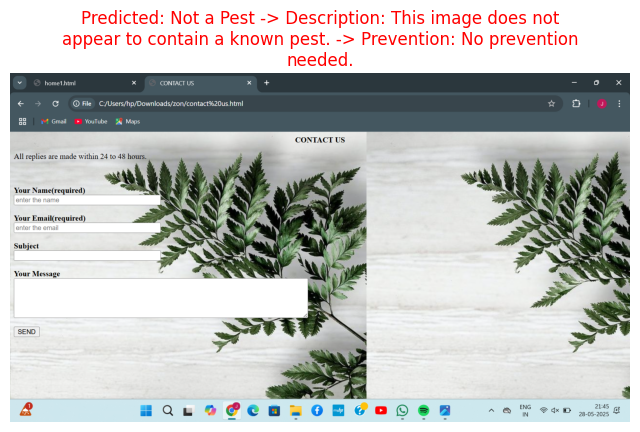

Predicted: Not a Pest (Confidence: 0.08)
Description: This image does not appear to contain a known pest.
Prevention: No prevention needed.


In [ ]:
import torch
import matplotlib.pyplot as plt
from textwrap import wrap
import json
from PIL import Image
from torchvision import transforms
from google.colab import files

# 📥 Load pest details from JSON
with open('/content/drive/MyDrive/Pest_classification_detection/pest.pest_details.json') as f:
    pest_data = json.load(f)

pest_info_map = {entry['name']: entry for entry in pest_data}

# 🧠 Load model
model = InsectModel(num_classes=40)
model.load_state_dict(torch.load("/content/drive/MyDrive/Pest_classification_detection/vit_best.pth", map_location=device))
model = model.to(device)
model.eval()

# 🔄 Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 📤 Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# 🖼️ Load and preprocess
image_pil = Image.open(image_path).convert("RGB")
input_tensor = transform(image_pil).unsqueeze(0).to(device)

# 🔍 Run inference
with torch.no_grad():
    outputs = model(input_tensor).softmax(1)
    max_prob, pred_class = outputs.max(1)
    max_prob = max_prob.item()
    pred_class = pred_class.item()

# ⚠️ Confidence threshold
CONF_THRESHOLD = 0.6  # adjust after testing

if max_prob < CONF_THRESHOLD:
    predicted_name = "Not a Pest"
    description = "This image does not appear to contain a known pest."
    prevention = "No prevention needed."
else:
    predicted_name = classes.name[pred_class]
    info = pest_info_map.get(predicted_name, {})
    description = info.get('description', 'No description available.').split("\r\n")[0]
    prevention = info.get('prevention', 'No prevention info available.').split("\r\n")[0]

# 📝 Display result
plt.figure(figsize=(8, 8))
plt.imshow(image_pil)
title_text = f"""Predicted: {predicted_name}
-> Description: {description}
-> Prevention: {prevention}"""
plt.title("\n".join(wrap(title_text, 60)), color='g' if predicted_name != "Not a Pest" else 'r')
plt.axis('off')
plt.show()

print(f"Predicted: {predicted_name} (Confidence: {max_prob:.2f})")
print(f"Description: {description}")
print(f"Prevention: {prevention}")
